In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import os
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
from matplotlib import image
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def image_preprocess(path, train_split, val_split, batch_size, inp_size):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  transform=transforms.Compose([transforms.Resize(inp_size[0]), transforms.RandomVerticalFlip(), 
                                transforms.CenterCrop(inp_size[0]), transforms.ToTensor(), normalize])
  data = datasets.ImageFolder(root=path, transform=transform)
  test_split = round((1-train_split-val_split), 2)
  data_length = len(data)

  print(data_length, int(train_split*data_length),int(val_split*data_length), int(test_split*data_length))

  train_size = int(train_split*data_length)
  val_size = int(val_split*data_length)
  test_size = data_length - val_size - train_size

# The no. of images in each split of train, val and test
  train_data, val_data, test_data = td.random_split(data, [train_size, val_size, 
                                                    test_size])

  # Create the data loaders
  train_loader = td.DataLoader(train_data,  batch_size=batch_size, 
                               shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  val_loader = td.DataLoader(val_data,  batch_size=batch_size, 
                             shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  test_loader = td.DataLoader(test_data, batch_size=batch_size, 
                              shuffle=True, drop_last=False, pin_memory=True, num_workers=2)
  
  return train_loader, val_loader, test_loader

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, lossFunc, epochs=15):
    start = time.time()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))

    best_model_weights = model.state_dict()
    best_accuracy = 0

    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1,epochs+1):

      for i, train_batch in enumerate(train_loader):
        images, labels, model = train_batch[0].to(device), train_batch[1].to(device), model.to(device)

        outputs = model(images)
        loss = lossFunc(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()

        for j, val_batch in enumerate(val_loader):
          images_, labels_ = val_batch[0].to(device), val_batch[1].to(device)
          outputs_ = model(images_)
          loss_ = lossFunc(outputs_, labels_)
          total_ = labels_.size(0)
          _,predicted_ = torch.max(outputs_.data, 1)
          correct_ = (predicted_ == labels_).sum().item()

        train_loss = loss.item()
        train_accuracy = (correct / total) * 100
        train_accuracy_list.append(train_accuracy)
        val_loss = loss_.item()
        val_accuracy = (correct_ / total_) * 100
        val_accuracy_list.append(val_accuracy)

        if val_accuracy > best_accuracy:
          best_accuracy = val_accuracy
          best_model_weights = model.state_dict()

        print("Epoch [{}/{}], Train_Loss: {:.4f}, Train_Accuracy: {:.2f}%  Val_Loss: {:.4f}, Val_Accuracy: {:.2f}%"
                .format(epoch, epochs, train_loss, train_accuracy, val_loss, val_accuracy))
      # checkpoint_resNet = {
      # "model": resNet,
      # "train_accuracy_list": train_accuracy_list,
      # "val_accuracy_list": val_accuracy_list,
      # "state_dict": resNet.state_dict()
      # }

      # torch.save(checkpoint_resNet, "/content/drive/MyDrive/Colab Notebooks/AI_lab/AI Final Project/resNet50.pth")
    end = time.time()    
    print("######## Training Finished in {} seconds ###########".format(end-start))
    model.load_state_dict(best_model_weights)
    return model, best_model_weights, train_accuracy_list, val_accuracy_list
    

In [ ]:
def evaluate_accuracy(model, test_loader):
  model.eval() 
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model2 = model.to(device)
  with torch.no_grad(): 
      correct = 0
      total = 0
      for data in test_loader:
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model2(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
      print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))
      
  return total, (correct / total) * 100

# Evaluation Metrics

## Dataset-1

### ResNet50

In [ ]:
path="/content/drive/MyDrive/AI Final Project/23Class"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

10662 7463 1066 2132


In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_tl_23.pth")

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/23Class"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()



In [ ]:
evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 2133 test images: 78.19971870604782 %


(2133, 78.19971870604782)

In [ ]:
import numpy as np

In [ ]:
def visualization(model, test_loader, path):
    
    y_true = []
    y_pred = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    for data in test_loader:
      images,labels=data[0].to(device),data[1]
      y_true.extend(labels.numpy())
      outputs=model(images)
      _, predicted = torch.max(outputs, 1)
      y_pred.extend(predicted.cpu().numpy())

    cf_matrix = confusion_matrix(y_true, y_pred)
    class_names = []
    for class_name in os.listdir(path):
        class_names.append(class_name)
    print(classification_report(y_true, y_pred, target_names=tuple(class_names)))  
    
    # Create pandas dataframe
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
    
    plt.title("Confusion Matrix"), plt.tight_layout()
    
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()

In [ ]:
import torch
torch.cuda.empty_cache()

                              precision    recall  f1-score   support

ulcerative-colitis-grade-1-2       0.00      0.00      0.00         9
            retroflex-rectum       0.00      0.00      0.00        11
                       cecum       0.94      0.89      0.92       131
                       ileum       0.95      0.88      0.91       223
  ulcerative-colitis-grade-1       0.86      0.95      0.90       230
                 hemorrhoids       0.68      0.73      0.70       201
ulcerative-colitis-grade-0-1       0.70      0.67      0.68       189
  ulcerative-colitis-grade-2       0.15      0.04      0.06        73
                      polyps       0.52      0.46      0.49        48
ulcerative-colitis-grade-2-3       0.00      0.00      0.00         1
           retroflex-stomach       0.00      0.00      0.00         1
  ulcerative-colitis-grade-3       0.41      0.88      0.56        25
                    bbps-0-1       0.98      0.94      0.96       196
                   

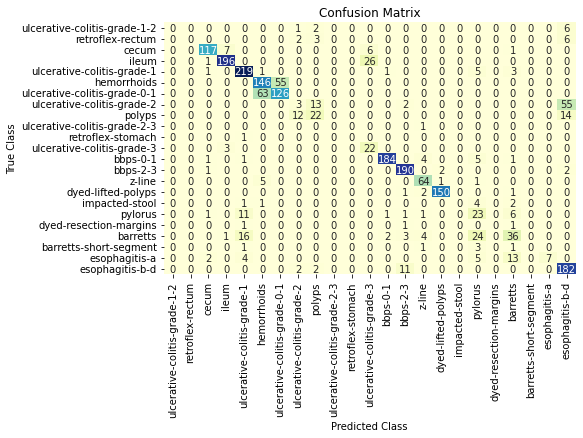

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

### DenseNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/denseNet_23.pth")

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 23)
Dense_net.load_state_dict(denseNet['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(Dense_net, test_loader)

Test Accuracy of the model on the 2133 test images: 81.38771683075481 %


(2133, 81.38771683075481)

                              precision    recall  f1-score   support

ulcerative-colitis-grade-1-2       0.00      0.00      0.00         9
            retroflex-rectum       0.00      0.00      0.00        11
                       cecum       0.95      0.88      0.91       131
                       ileum       0.89      0.98      0.93       223
  ulcerative-colitis-grade-1       0.86      0.95      0.90       230
                 hemorrhoids       0.69      0.94      0.80       201
ulcerative-colitis-grade-0-1       0.90      0.57      0.70       189
  ulcerative-colitis-grade-2       0.00      0.00      0.00        73
                      polyps       0.64      0.48      0.55        48
ulcerative-colitis-grade-2-3       0.00      0.00      0.00         1
           retroflex-stomach       0.00      0.00      0.00         1
  ulcerative-colitis-grade-3       0.65      0.60      0.63        25
                    bbps-0-1       0.98      0.96      0.97       196
                   

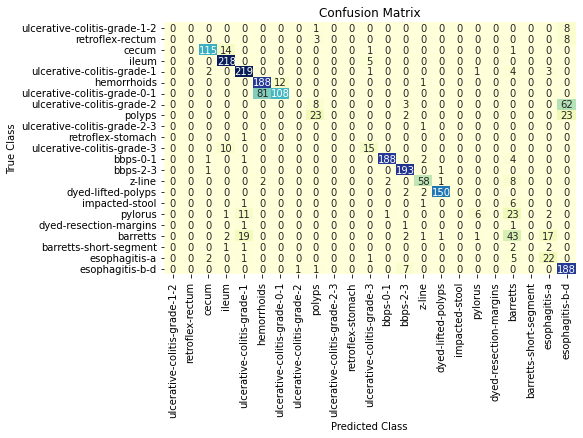

In [ ]:
visualization(Dense_net, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

### VGG

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg_23.pth")

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 23)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(vgg['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 2133 test images: 90.90482887951242 %


(2133, 90.90482887951242)

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/23Class")

ValueError: ignored

### Dataset-2

In [ ]:
path="/content/drive/MyDrive/AI Final Project/eightClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

4000 2800 400 800


### ResNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "/content/drive/MyDrive/AI Final Project/eightClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 800 test images: 13.125 %


(800, 13.125)

                        precision    recall  f1-score   support

        normal-pylorus       0.00      0.00      0.00        90
         normal-z-line       0.00      0.00      0.00       100
                polyps       0.16      0.96      0.27       102
           esophagitis       0.00      0.00      0.00       102
dyed-resection-margins       0.04      0.07      0.05       100
    dyed-lifted-polyps       0.00      0.00      0.00       104
    ulcerative-colitis       0.00      0.00      0.00       109
          normal-cecum       0.00      0.00      0.00        93

              accuracy                           0.13       800
             macro avg       0.02      0.13      0.04       800
          weighted avg       0.03      0.13      0.04       800



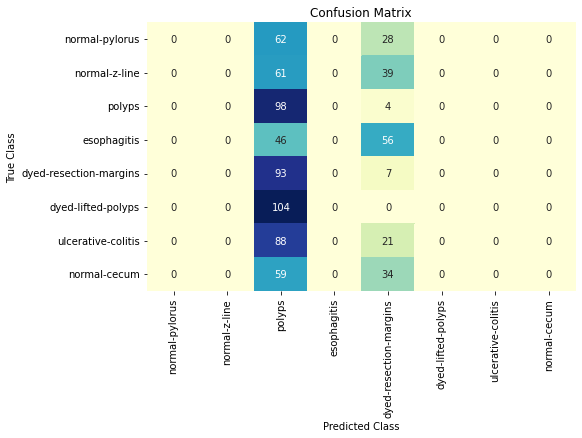

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### DenseNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
Dense_net = torchvision.models.densenet121()
num_filters = Dense_net.classifier.in_features
Dense_net.classifier = torch.nn.Linear(num_filters, 8)
Dense_net.load_state_dict(denseNet['state_dict'])

optimizer = torch.optim.Adam(params=Dense_net.parameters())
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(Dense_net, test_loader)

Test Accuracy of the model on the 800 test images: 25.374999999999996 %


(800, 25.374999999999996)

                        precision    recall  f1-score   support

        normal-pylorus       0.52      0.14      0.23        90
         normal-z-line       0.64      0.09      0.16       100
                polyps       0.00      0.00      0.00       102
           esophagitis       0.00      0.00      0.00       102
dyed-resection-margins       0.19      0.82      0.30       100
    dyed-lifted-polyps       0.72      0.12      0.21       104
    ulcerative-colitis       0.00      0.00      0.00       109
          normal-cecum       0.29      0.91      0.43        93

              accuracy                           0.25       800
             macro avg       0.29      0.26      0.17       800
          weighted avg       0.29      0.25      0.16       800



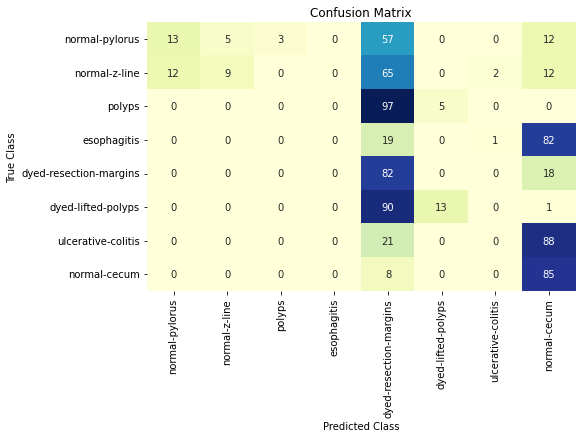

In [ ]:
visualization(Dense_net, test_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### VGG

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_eightclass.pth")

In [ ]:
model = torchvision.models.vgg16()
num_features =model.classifier[6].in_features
features = list(model.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, 8)]) 
model.classifier = nn.Sequential(*features)
model.load_state_dict(vgg['state_dict'])
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)
loss = torch.nn.CrossEntropyLoss()

In [ ]:
evaluate_accuracy(model, test_loader)

Test Accuracy of the model on the 800 test images: 23.75 %


(800, 23.75)

                        precision    recall  f1-score   support

        normal-pylorus       0.29      0.02      0.04        90
         normal-z-line       0.47      0.42      0.44       100
                polyps       0.17      0.91      0.29       102
           esophagitis       0.00      0.00      0.00       102
dyed-resection-margins       1.00      0.01      0.02       100
    dyed-lifted-polyps       0.55      0.12      0.19       104
    ulcerative-colitis       0.27      0.32      0.29       109
          normal-cecum       0.22      0.02      0.04        93

              accuracy                           0.23       800
             macro avg       0.37      0.23      0.16       800
          weighted avg       0.37      0.23      0.17       800



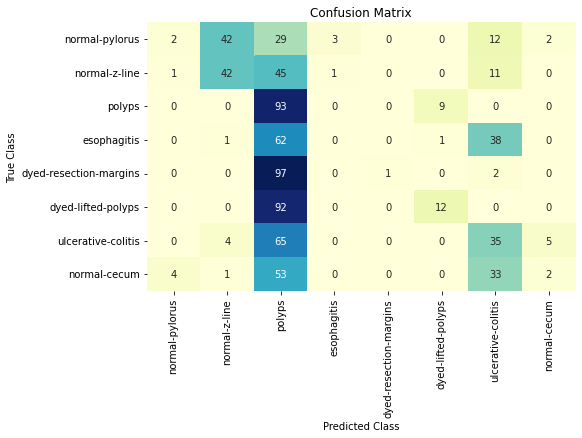

In [ ]:
visualization(model, test_loader, "/content/drive/MyDrive/AI Final Project/eightClass")

### Dataset-3

In [ ]:
path="/content/drive/MyDrive/AI Final Project/fourClass"
train_loader, val_loader, test_loader = image_preprocess(path, 0.7, 0.1, 32, (224,224))

4000 2800 400 800


ResNet

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_fourclass.pth")

In [ ]:
model = resnet50()
num_ftrs = model.fc.in_features
path = "//content/drive/MyDrive/AI Final Project/fourClass"
classes = os.listdir(path+"/")
model.fc = torch.nn.Linear(num_ftrs, len(classes))
model.load_state_dict(resNet['state_dict'])
optimizer = torch.optim.Adam(params=model.parameters())
loss = torch.nn.CrossEntropyLoss()

RuntimeError: ignored

### Dataset-3

# Dataset-3

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_fourclass.pth")

In [ ]:
resNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/dense_net_4.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_4.pth")

In [ ]:
type(vgg)

function

In [ ]:
resNet_train, resNet_val = resNet['training_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%100==0):
            accuracy.append(sum/100)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

NameError: ignored

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

# Dataset-2

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
resNet.keys()

dict_keys(['model', 'train_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg16_eightclass.pth")

In [ ]:
vgg.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
resNet_train, resNet_val = resNet['train_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
def train_val_comparison_individual(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="train accuracy")
    plt.plot(x, train_accuracy_list_2, label="validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train vs Validation")
    plt.legend()

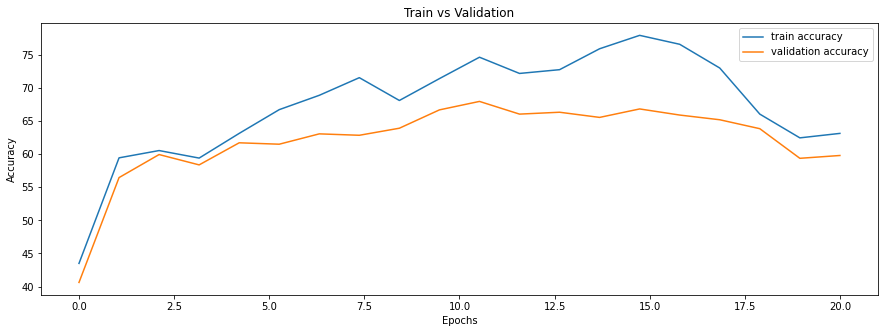

In [ ]:
train_val_comparison_individual(train_accuracy_1, val_accuracy_1, train_loader)

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

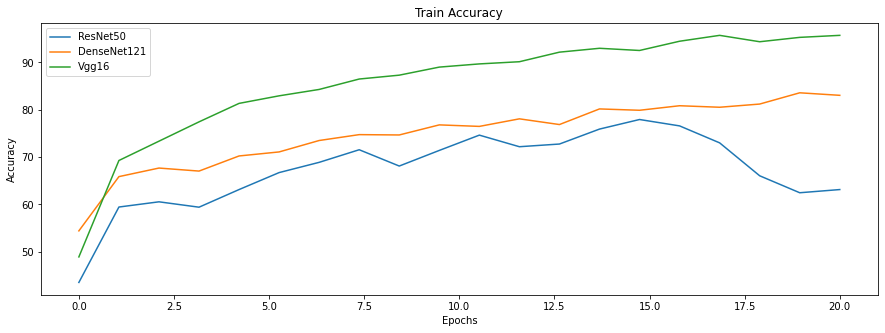

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

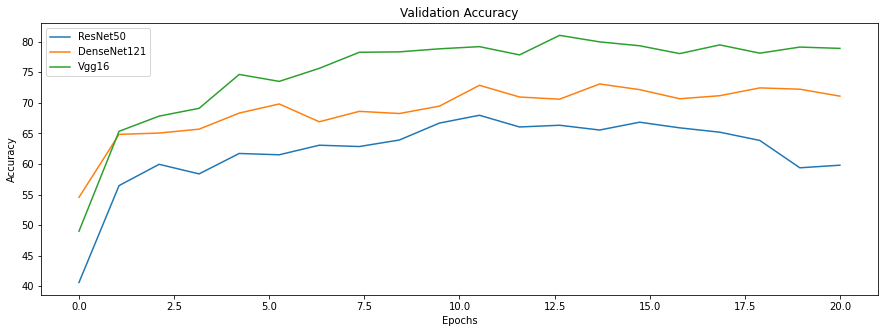

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

In [ ]:
def subplot(train_accuracy_list_1,train_accuracy_list_2,train_accuracy_list_3,val_accuracy_list_1,val_accuracy_list_2,val_accuracy_list_3):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)    
    plt.plot(x, train_accuracy_list_1, label="Train accuracy")
    plt.plot(x, val_accuracy_list_1, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("ResNet50")
    plt.legend()
    plt.subplot(1,3,2)    
    plt.plot(x, train_accuracy_list_2, label="Train accuracy")
    plt.plot(x, val_accuracy_list_2, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("DenseNet121")
    plt.legend()
    plt.subplot(1,3,3)    
    plt.plot(x, train_accuracy_list_3, label="Train accuracy")
    plt.plot(x, val_accuracy_list_3, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Vgg16")
    plt.suptitle("Train vs Validation")
    plt.legend()


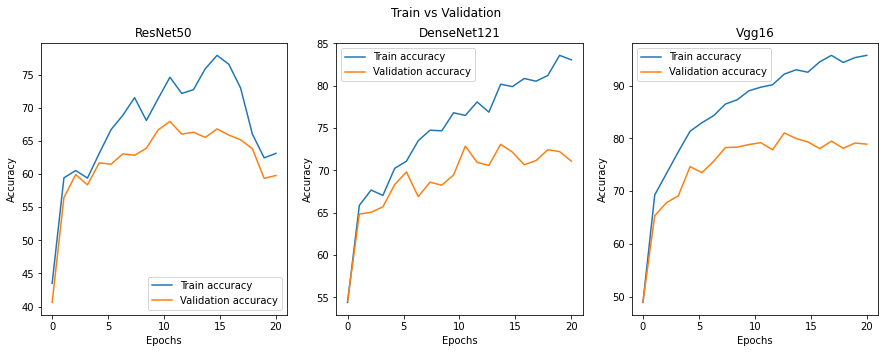

In [ ]:
subplot(train_accuracy_1,train_accuracy_2,train_accuracy_3,val_accuracy_1,val_accuracy_2,val_accuracy_3)

# Dataset-1

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet_tl_23.pth")

In [ ]:
resNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/denseNet_23.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'state_dict', 'train_accuracy_list', 'val_accuracy_list'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
vgg = load_checkpoint("/content/drive/MyDrive/AI Final Project/vgg_23.pth")

In [ ]:
vgg.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
resNet_train, resNet_val = resNet['training_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
denseNet_train, denseNet_val = denseNet['train_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
vgg_train, vgg_val = vgg['training_accuracy_list'], vgg['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%234==0):
            accuracy.append(sum/234)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2, train_accuracy_3 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(vgg_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, train_accuracy_list_3, loader_length):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121")
    plt.plot(x, train_accuracy_list_3, label="Vgg16")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation")
    plt.legend()

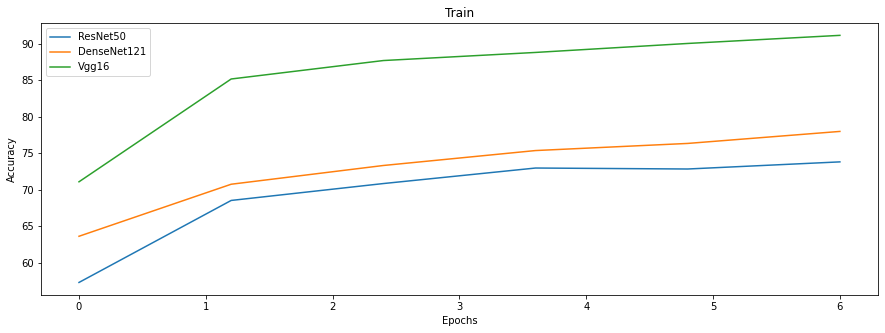

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, train_accuracy_3, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2, val_accuracy_3 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(vgg_val)

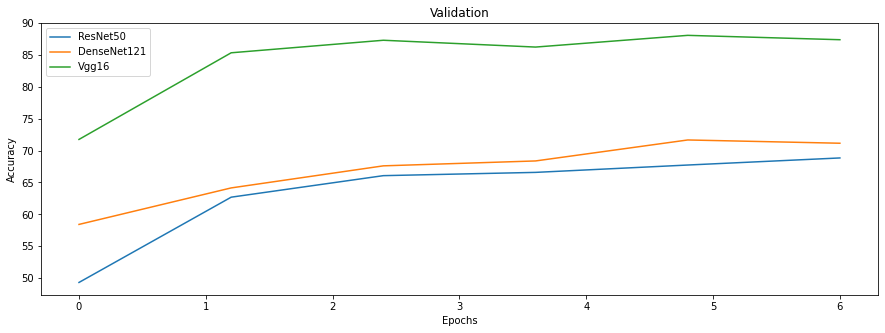

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, val_accuracy_3, len(train_loader))

In [ ]:

def subplot(train_accuracy_list_1,train_accuracy_list_2,train_accuracy_list_3,val_accuracy_list_1,val_accuracy_list_2,val_accuracy_list_3):
    x = np.linspace(0, 6, num=6)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)    
    plt.plot(x, train_accuracy_list_1, label="Train accuracy")
    plt.plot(x, val_accuracy_list_1, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("ResNet50")
    plt.legend()
    plt.subplot(1,3,2)    
    plt.plot(x, train_accuracy_list_2, label="Train accuracy")
    plt.plot(x, val_accuracy_list_2, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("DenseNet121")
    plt.legend()
    plt.subplot(1,3,3)    
    plt.plot(x, train_accuracy_list_3, label="Train accuracy")
    plt.plot(x, val_accuracy_list_3, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Vgg16")
    plt.suptitle("Train vs Validation")
    plt.legend()


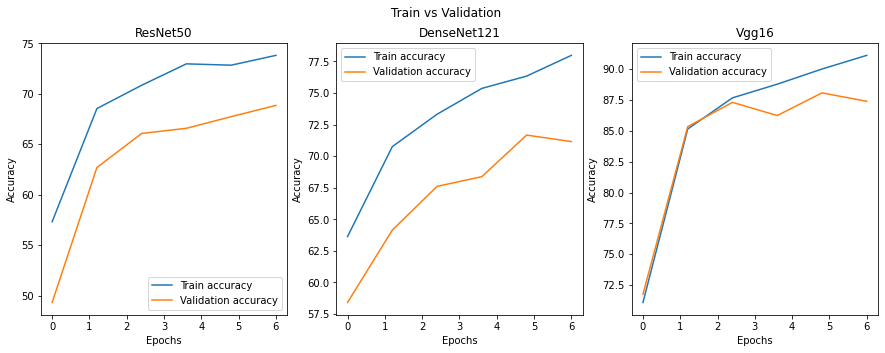

In [ ]:
subplot(train_accuracy_1,train_accuracy_2,train_accuracy_3,val_accuracy_1,val_accuracy_2,val_accuracy_3)

# Transfer Learning

## ResNet50

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50.pth")

In [ ]:
resNet.keys()

dict_keys(['model', 'train_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
resNet_tl = load_checkpoint("/content/drive/MyDrive/AI Final Project/resNet50_tl.pth")

In [ ]:
resNet_tl.keys()

dict_keys(['model', 'state_dict', 'train_accuracy_list', 'val_accuracy_list'])

In [ ]:
resNet_train, resNet_val = resNet['train_accuracy_list'], resNet['val_accuracy_list']

In [ ]:
resNet_tl_train, resNet_tl_val = resNet_tl['train_accuracy_list'], resNet_tl['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(resNet_train), accuracyForEachEpoch(resNet_tl_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="ResNet50")
    plt.plot(x, train_accuracy_list_2, label="ResNet50 with Transfer learning")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

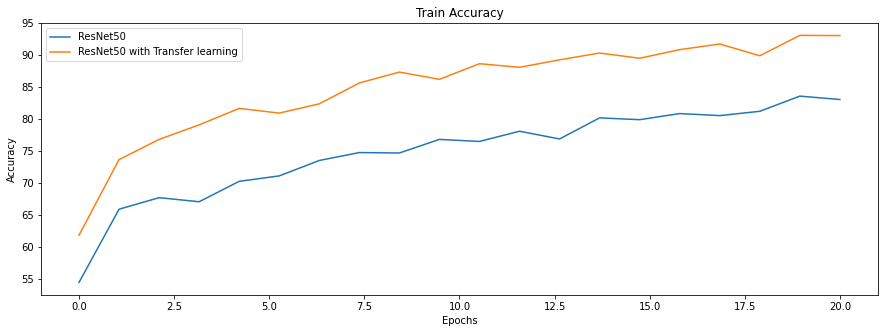

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(resNet_val), accuracyForEachEpoch(resNet_tl_val)

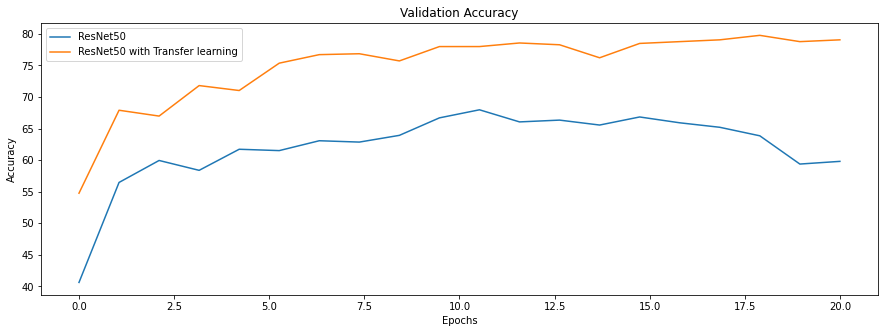

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, len(train_loader))

## DenseNet121

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet_lr = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet_lr.pth")

In [ ]:

denseNet_lr.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
denseNet_train, denseNet_val = denseNet['training_accuracy_list'], denseNet['val_accuracy_list']

In [ ]:
denseNet_tl_train, denseNet_tl_val = denseNet_lr['training_accuracy_list'], denseNet_lr['val_accuracy_list']

In [ ]:
def accuracyForEachEpoch(accuracy_list):
    accuracy = []
    sum = 0
    for i, v in enumerate(accuracy_list):

        if((i+1)%88==0):
            accuracy.append(sum/88)
            sum = 0
        else: 
            sum += v

    return accuracy

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(denseNet_train), accuracyForEachEpoch(denseNet_tl_train)

In [ ]:
def train_val_comparison(train_accuracy_list_1, train_accuracy_list_2, loader_length):
    x = np.linspace(0, 20, num=20)
    plt.figure(figsize=(15,5))
    plt.plot(x, train_accuracy_list_1, label="DenseNet121")
    plt.plot(x, train_accuracy_list_2, label="DenseNet121 with Transfer learning")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Train Accuracy")
    plt.legend()

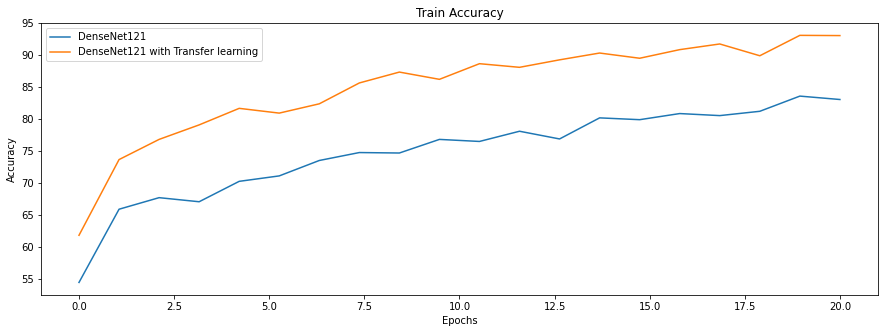

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, len(train_loader))

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(denseNet_val), accuracyForEachEpoch(denseNet_tl_val)

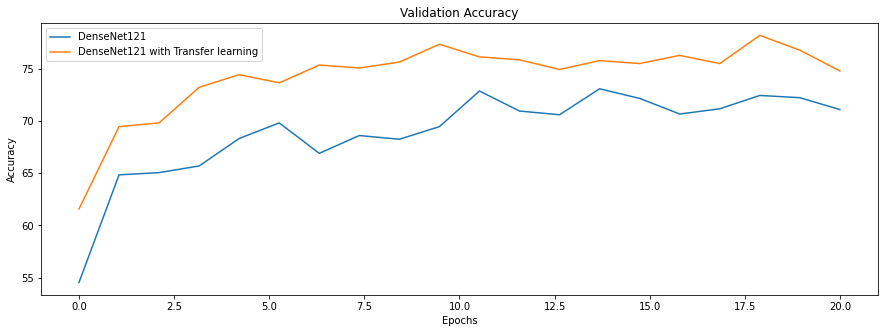

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, len(train_loader))

# Hyper-parameter tuning

## Learning rate

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet = load_checkpoint("/content/drive/MyDrive/AI Final Project/checkpoint_denseNet.pth")

In [ ]:
denseNet.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return checkpoint
denseNet_best = load_checkpoint("/content/drive/MyDrive/AI Final Project/dense_net_bestLR8Class1.pth")

In [ ]:
denseNet_best.keys()

dict_keys(['model', 'training_accuracy_list', 'val_accuracy_list', 'state_dict'])

In [ ]:
train_accuracy_1, train_accuracy_2 = accuracyForEachEpoch(denseNet["training_accuracy_list"]), accuracyForEachEpoch(denseNet_best["training_accuracy_list"])

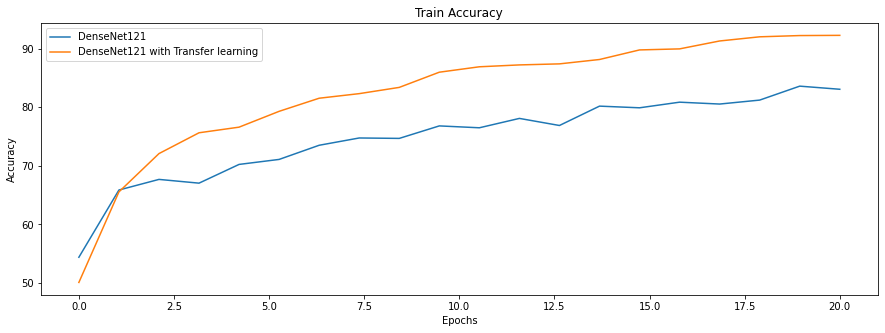

In [ ]:
train_val_comparison(train_accuracy_1, train_accuracy_2, _)

In [ ]:
val_accuracy_1, val_accuracy_2 = accuracyForEachEpoch(denseNet["val_accuracy_list"]), accuracyForEachEpoch(denseNet_best["val_accuracy_list"])

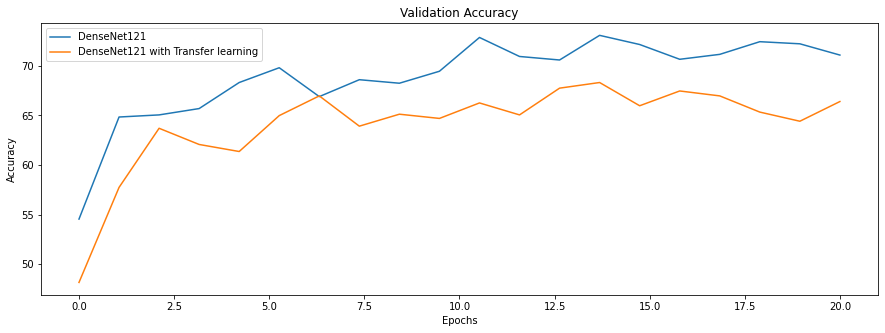

In [ ]:
train_val_comparison(val_accuracy_1, val_accuracy_2, _)